# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

# TO-DO
- Write just one model
- Better frames for datasets
- Regression

In [1]:
from sklearn.svm import SVC
from sklearn.svm import SVR, LinearSVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import tqdm
import config
import math
import os
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset, filter_faces
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay, roc_auc_score, roc_curve, det_curve




No face detected


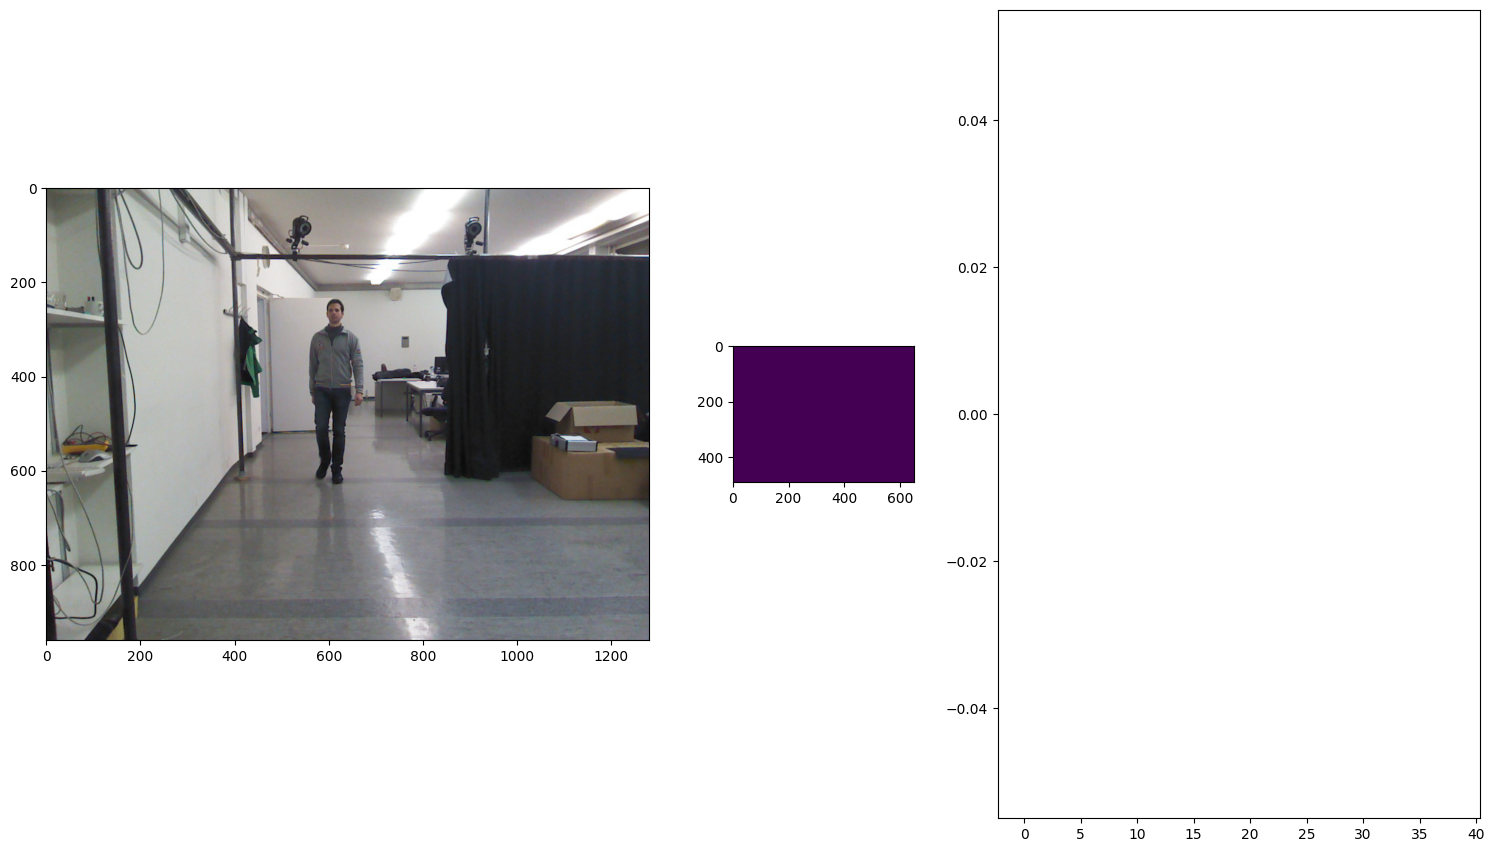

No face detected


In [94]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [95]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

    skel_pred_roc = model_skel.predict_proba(X_skel_test)
    clothes_pred_roc = model_clothes.predict_proba(X_clothes_test)
    face_pred_roc = model_face.predict_proba(X_face_test)

In [96]:
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)



In [99]:

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=2, splitter='best'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 4),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=9, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))
# fig, (ax_roc_skel, ax_roc_clothes, ax_roc_face, ax_det_skel, ax_det_clothes, ax_det_face) = plt.subplots(1, 6, figsize=(50,5))

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))

for name, model in classifiers_skel.items():

    fprs = []
    tprs = []
    fprs2 = []
    tprs2 = []
    roc_aucs = []
    # fit the model for each training sample and average the fpr, tpr and roc_auc
    for i in range(0, 7):
        X = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_X.npy")
        y = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_y.npy")
        X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(
            X, y)

        X_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_X.npy")
        y_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_y.npy")
        X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(
            X_2, y_2)

        model.fit(PolynomialFeatures().fit_transform(X_skel), y_train)
        res = model.predict_proba(PolynomialFeatures().fit_transform(X_skel_test))[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, res)
        auc = roc_auc_score(y_test, res)
        roc_aucs.append(auc)
    
        fprs.append(fpr)
        tprs.append(tpr)

        fpr2, tpr2, thresholds2 = det_curve(y_test, res)
        fprs2.append(fpr2)
        tprs2.append(tpr2)


    longest_fpr = len(max(fprs, key=len))
    longest_tpr = len(max(tprs, key=len))
    longest_fpr2 = len(max(fprs2, key=len))
    longest_tpr2 = len(max(tprs2, key=len))


    # pad the shorter arrays with the last value
    for i in range(0, len(fprs)):
        fprs[i] = np.pad(fprs[i], (0, longest_fpr - len(fprs[i])), 'edge')
        tprs[i] = np.pad(tprs[i], (0, longest_tpr - len(tprs[i])), 'edge')
    
    for i in range(0, len(fprs2)):
        fprs2[i] = np.pad(fprs2[i], (0, longest_fpr2 - len(fprs2[i])), 'edge')
        tprs2[i] = np.pad(tprs2[i], (0, longest_tpr2 - len(tprs2[i])), 'edge')
    



    # average the fpr and tpr and calculate the auc
    fpr = np.mean(fprs, axis=0)
    tpr = np.mean(tprs, axis=0)
    fpr2 = np.mean(fprs2, axis=0)
    tpr2 = np.mean(tprs2, axis=0)

    auc = np.mean(roc_aucs)

    ax_roc_skel.plot(fpr, tpr, label=name + " (AUC = " + str(round(auc, 2)) + ")")
    ax_det_skel.plot(fpr2, tpr2, label=name)


    




for name, model in classifiers_clothes.items():

    fprs = []
    tprs = []  
    fprs2 = []
    tprs2 = []
    roc_aucs = []
    # fit the model for each training sample and average the fpr, tpr and roc_auc
    for i in range(0, 7):
        X = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_X.npy")
        y = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_y.npy")
        X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(
            X, y)

        X_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_X.npy")
        y_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_y.npy")
        X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(
            X_2, y_2)

        model.fit(PolynomialFeatures().fit_transform(X_clothes), y_train)
        res = model.predict_proba(PolynomialFeatures().fit_transform(X_clothes_test))[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, res)
        auc = roc_auc_score(y_test, res)
        roc_aucs.append(auc)
    
        fprs.append(fpr)
        tprs.append(tpr)

        fpr2, tpr2, thresholds2 = det_curve(y_test, res)
        fprs2.append(fpr2)
        tprs2.append(tpr2)

    longest_fpr = len(max(fprs, key=len))
    longest_tpr = len(max(tprs, key=len))
    longest_fpr2 = len(max(fprs2, key=len))
    longest_tpr2 = len(max(tprs2, key=len))

    # pad the shorter arrays with the last value
    for i in range(0, len(fprs)):
        fprs[i] = np.pad(fprs[i], (0, longest_fpr - len(fprs[i])), 'edge')
        tprs[i] = np.pad(tprs[i], (0, longest_tpr - len(tprs[i])), 'edge')

    for i in range(0, len(fprs2)):
        fprs2[i] = np.pad(fprs2[i], (0, longest_fpr2 - len(fprs2[i])), 'edge')
        tprs2[i] = np.pad(tprs2[i], (0, longest_tpr2 - len(tprs2[i])), 'edge')


    # average the fpr and tpr and calculate the auc
    fpr = np.mean(fprs, axis=0)
    tpr = np.mean(tprs, axis=0)
    fpr2 = np.mean(fprs2, axis=0)
    tpr2 = np.mean(tprs2, axis=0)

    auc = np.mean(roc_aucs)   

    ax_roc_clothes.plot(fpr, tpr, label=name + " (AUC = " + str(round(auc, 2)) + ")")
    ax_det_clothes.plot(fpr2, tpr2, label=name)


for name, model in classifiers_face.items():

    fprs = []
    tprs = []
    fprs2 = []
    tprs2 = []
    roc_aucs = []
    # fit the model for each training sample and average the fpr, tpr and roc_auc
    for i in range(0, 7):
        X = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_X.npy")
        y = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_0_y.npy")
        X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(
            X, y)

        X_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_X.npy")
        y_2 = np.load(config.SAMPLED_PATH + "video_" + str(i) + "_sample_1_y.npy")
        X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(
            X_2, y_2)

        model.fit(PolynomialFeatures().fit_transform(X_face), y_face)
        res = model.predict_proba(PolynomialFeatures().fit_transform(X_face_test))[:, 1]
        fpr, tpr, thresholds = roc_curve(y_face_test, res)
        auc = roc_auc_score(y_face_test, res)
        roc_aucs.append(auc)
    
        fprs.append(fpr)
        tprs.append(tpr)

        fpr2, tpr2, thresholds2 = det_curve(y_face_test, res)
        fprs2.append(fpr2)
        tprs2.append(tpr2)
    
    longest_fpr = len(max(fprs, key=len))
    longest_tpr = len(max(tprs, key=len))
    longest_fpr2 = len(max(fprs2, key=len))
    longest_tpr2 = len(max(tprs2, key=len))

    # pad the shorter arrays with the last value
    for i in range(0, len(fprs)):
        fprs[i] = np.pad(fprs[i], (0, longest_fpr - len(fprs[i])), 'edge')
        tprs[i] = np.pad(tprs[i], (0, longest_tpr - len(tprs[i])), 'edge')
    
    for i in range(0, len(fprs2)):
        fprs2[i] = np.pad(fprs2[i], (0, longest_fpr2 - len(fprs2[i])), 'edge')
        tprs2[i] = np.pad(tprs2[i], (0, longest_tpr2 - len(tprs2[i])), 'edge')
    
    # average the fpr and tpr and calculate the auc
    fpr = np.mean(fprs, axis=0)
    tpr = np.mean(tprs, axis=0)
    fpr2 = np.mean(fprs2, axis=0)
    tpr2 = np.mean(tprs2, axis=0)

    auc = np.mean(roc_aucs)

    ax_roc_face.plot(fpr, tpr, label=name + " (AUC = " + str(round(auc, 2)) + ")")
    ax_det_face.plot(fpr2, tpr2, label=name)
    


# Add Labels
ax_roc_skel.set_xlabel("False Positive Rate")
ax_det_skel.set_xlabel("Detection Error Rate")
ax_roc_clothes.set_xlabel("False Positive Rate")
ax_det_clothes.set_xlabel("Detection Error Rate")
ax_roc_face.set_xlabel("False Positive Rate")
ax_det_face.set_xlabel("Detection Error Rate")

ax_roc_clothes.set_ylabel("True Positive Rate")
ax_det_clothes.set_ylabel("Detection Rate")
ax_roc_face.set_ylabel("True Positive Rate")
ax_det_face.set_ylabel("Detection Rate")
ax_roc_skel.set_ylabel("True Positive Rate")
ax_det_skel.set_ylabel("Detection Rate")

# Add Legends
ax_roc_skel.legend(loc="lower right")
ax_det_skel.legend(loc="upper right")
ax_roc_clothes.legend(loc="lower right")
ax_det_clothes.legend(loc="upper right")
ax_roc_face.legend(loc="lower right")
ax_det_face.legend(loc="upper right")




ax_roc_skel.grid(linestyle="--")
ax_det_skel.grid(linestyle="--")
ax_roc_clothes.grid(linestyle="--")
ax_det_clothes.grid(linestyle="--")
ax_roc_face.grid(linestyle="--")
ax_det_face.grid(linestyle="--")


plt.legend()
plt.savefig("ROC_DET_curves.png")

## Model Tuning

### Fit and Evaluate Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


class_names = ['Different', 'Same']

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models,model_name,X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        if name.count("accuracy")> 0:
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            disp.plot(cmap=plt.cm.Blues)
            disp.ax_.set_title(name + ' (' + model_name + ')') 
        print('------------------------------------'*3)
    return  

### Model Tuning

In [ ]:

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    best_params = clf.best_params_.copy()
    return best_params

### Models

In [ ]:

SVM_param_grid = {
    'C': [0.5, 1],
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [1,2,3,4,5],
    'gamma': ['scale'],
    'random_state': [2,42]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}


Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

KNN_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Regres_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.5, 1],
    'fit_intercept': [True, False],
    'intercept_scaling': [1, 2, 3],
    'class_weight': [None, 'balanced'],
    'random_state': [2,42],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'verbose': [0],
    'warm_start': [True, False],
    'n_jobs': [-1],
    'l1_ratio': [None]
}

models = {
    "KNN": (KNeighborsClassifier, KNN_param_grid),
    "DT": (DecisionTreeClassifier, DT_param_grid),
    "RF": (RandomForestClassifier, RF_param_grid),
    "GNB": (GaussianNB, Gauss_param_grid),
    "SVM": (SVC, SVM_param_grid),
    # "LogReg": (LogisticRegression(), Regres_param_grid),
}

### Tuning and Evaluation

In [ ]:

for model in models:
    print(model)
    current_model = models[model]
    best_accuracy_params_skel = tune_model(current_model[0](), current_model[1], 'accuracy', X_skel, y_train, -1)
    best_f1macro_params_skel = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_skel, y_train, -1)
    best_accuracy_params_clothes = tune_model(current_model[0](), current_model[1], 'accuracy', X_clothes, y_train, -1)
    best_f1macro_params_clothes = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_clothes, y_train, -1)
    best_accuracy_params_face = tune_model(current_model[0](), current_model[1], 'accuracy', X_face, y_face, -1)
    best_f1macro_params_face = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_face, y_face, -1)
    tuned_models_skel = {
        'Skeleton accuracy': current_model[0](**best_accuracy_params_skel),
        'Skeleton f1_macro': current_model[0](**best_f1macro_params_skel)
    }

    tuned_models_clothes = {
        'Clothes accuracy': current_model[0](**best_accuracy_params_clothes),
        'Clothes f1_macro': current_model[0](**best_f1macro_params_clothes)
    }

    tuned_models_face = {
        'Face accuracy': current_model[0](**best_accuracy_params_face),
        'Face f1_macro': current_model[0](**best_f1macro_params_face)
    }
        
    fit_models(tuned_models_skel, X_skel, y_train)
    fit_models(tuned_models_clothes, X_clothes, y_train)
    fit_models(tuned_models_face, X_face, y_face)
    print("-"*50)
    print("Skeleton")
    evaluate_models(tuned_models_skel,model, X_skel, y_train)
    print("-"*50)
    print("Clothes")
    print("-"*50)
    evaluate_models(tuned_models_clothes,model, X_clothes, y_train)
    print("-"*50)
    print("Face")
    print("-"*50)
    evaluate_models(tuned_models_face,model, X_face, y_face)


### Results
| Model | Skeleton | Clothes | Face | 
| :--- | :---: | :---: | :---: | 
| DT | 0.91 | 0.93  | 0.81 |
| RF | 0.93 | 0.94  | 0.85 |
| SVC | 0.91 | 0.93  | 0.81 |
| GNB | 0.89 | 0.79  | 0.81 |
| KNN | 0.94 | 0.94  | 0.84 |

In [20]:
class FinalModel(BaseEstimator, ClassifierMixin):

    def __init__(self, policy='max', name = "FinalModel"):
        self.model_skel = RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
        self.model_clothes = RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 4)
        self.model_face = SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42)
        self.name = name
        self.classes_ = [0, 1]

    def fit(self, X, y):
        # prepare data
        features_skel = X[:, 0:9]
        features_clothes =  X[:, 9:9 + config.NUM_POINTS_LBP]
        features_face_not_filtered = X[:, 9 + config.NUM_POINTS_LBP:]
        features_face, y_face = filter_faces(features_face_not_filtered, y)

        # fit models
        self.model_skel.fit(features_skel, y)
        self.model_clothes.fit(features_clothes, y)
        self.model_face.fit(features_face, y_face)
        return self

    def predict(self, X):
        # features_skel = X[:, 0:9]
        # features_clothes =  X[:, 9:9 + config.NUM_POINTS_LBP]
        # features_face_not_filtered = X[:, 9 + config.NUM_POINTS_LBP:]
        
        # indexes = np.argwhere(~np.isnan(features_face_not_filtered[:, 0].reshape(-1)))
        # features_face = features_face_not_filtered[indexes.flatten()]
        
        # output_skel = self.model_skel.predict(features_skel)
        # output_clothes = self.model_clothes.predict(features_clothes)
        # o_face = self.model_face.predict(features_face)

        # output_face = np.zeros(len(X))
        # np.put(output_face, indexes, o_face)

        # output = np.bitwise_or(output_skel, output_clothes, output_face)



        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        features_skel = X[:, 0:9]
        features_clothes =  X[:, 9:9 + config.NUM_POINTS_LBP]
        features_face_not_filtered = X[:, 9 + config.NUM_POINTS_LBP:]

        # Get valid faces
        indexes = np.argwhere(~np.isnan(features_face_not_filtered[:, 0].reshape(-1)))
        features_face = features_face_not_filtered[indexes.flatten()]
        
        # Predict
        output_skel = self.model_skel.predict_proba(features_skel)
        output_clothes = self.model_clothes.predict_proba(features_clothes)
        o_face = self.model_face.predict_proba(features_face)

        # Insert face outputs in a new array
        output_face = np.asarray([np.asarray([0, 0]) for _ in range(len(X))])
        np.put(output_face, indexes, o_face)

        # calculate final probabilities
        output = (output_skel + output_clothes + output_face) / 3

        np.maximum(output_skel, np.maximum(output_clothes, output_face))
        
        return output

['video_0_sample_0_X.npy', 'video_0_sample_0_y.npy', 'video_0_sample_1_X.npy', 'video_0_sample_1_y.npy']
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1500
           1       1.00      0.34      0.51        50

    accuracy                           0.98      1550
   macro avg       0.99      0.67      0.75      1550
weighted avg       0.98      0.98      0.97      1550

['video_10_sample_0_X.npy', 'video_10_sample_0_y.npy', 'video_10_sample_1_X.npy', 'video_10_sample_1_y.npy']
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1500
           1       1.00      0.30      0.46        50

    accuracy                           0.98      1550
   macro avg       0.99      0.65      0.73      1550
weighted avg       0.98      0.98      0.97      1550

['video_11_sample_0_X.npy', 'video_11_sample_0_y.npy', 'video_11_sample_1_X.npy', 'video_11_sample_1_y.npy']
              precision

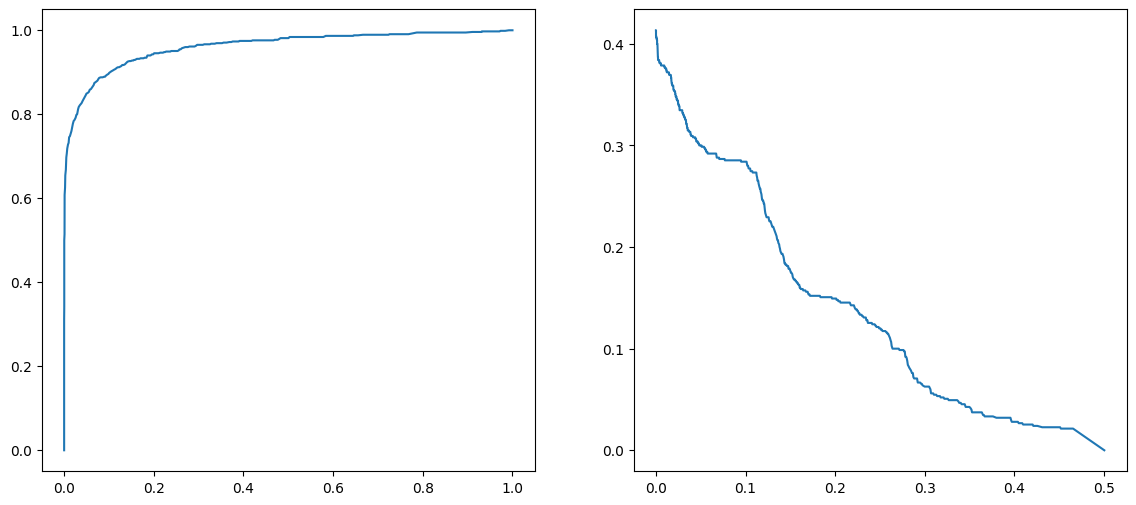

In [21]:

import re

files = [f for f in os.listdir("./sampled") if re.match("(video_)([0-9]*)(_sample_)([0-9]*)_([Xy])(.npy)", f)]
files.sort()
samples = [(files[i], files[i+1], files[i+2], files[i+3]) for i in range(0, len(files) - 2, 4)]

fig, (ax_roc, ax_det) = plt.subplots(1, 2)
fig.set_size_inches(14, 6)

fprs = []
tprs = []
fprs2 = []
tprs2 = []
roc_aucs = []
# fit the model for each training sample and average the fpr, tpr and roc_auc
for f_X, f_y, f_X_2, f_y_2 in samples:
    print([f_X, f_y, f_X_2, f_y_2])

    X = np.load("./sampled/" + f_X)
    y = np.load("./sampled/" + f_y)

    X_2 = np.load("./sampled/" + f_X_2)
    y_2 = np.load("./sampled/" + f_y_2)

    model = FinalModel()
    model.fit(X, y)

    res = model.predict_proba(X_2)[:, 1]

    print(classification_report(y_2, model.predict(X_2)))
    
    fpr, tpr, thresholds = roc_curve(y_2, res)
    auc = roc_auc_score(y_2, res)
    roc_aucs.append(auc)

    fprs.append(fpr)
    tprs.append(tpr)

    fpr2, tpr2, thresholds2 = det_curve(y_2, res)
    fprs2.append(fpr2)
    tprs2.append(tpr2)

longest_fpr = len(max(fprs, key=len))
longest_tpr = len(max(tprs, key=len))
longest_fpr2 = len(max(fprs2, key=len))
longest_tpr2 = len(max(tprs2, key=len))

# pad the shorter arrays with the last value
for i in range(0, len(fprs)):
    fprs[i] = np.pad(fprs[i], (0, longest_fpr - len(fprs[i])), 'edge')
    tprs[i] = np.pad(tprs[i], (0, longest_tpr - len(tprs[i])), 'edge')

for i in range(0, len(fprs2)):
    fprs2[i] = np.pad(fprs2[i], (0, longest_fpr2 - len(fprs2[i])), 'edge')
    tprs2[i] = np.pad(tprs2[i], (0, longest_tpr2 - len(tprs2[i])), 'edge')

# average the fpr and tpr and calculate the auc
fpr = np.mean(fprs, axis=0)
tpr = np.mean(tprs, axis=0)
fpr2 = np.mean(fprs2, axis=0)
tpr2 = np.mean(tprs2, axis=0)

auc = np.mean(roc_aucs)

ax_roc.plot(fpr, tpr, label="FinalModel (AUC = " + str(round(auc, 2)) + ")")
ax_det.plot(fpr2, tpr2, label="FinalModel")

In [ ]:
# Train the models on the big dataset

X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

model_skel = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance')#  RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
model_clothes = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance')# RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 42)
model_face = SVC(C = 1, kernel = "poly", degree = 3, gamma = "auto", probability = True, random_state = 2)


model_skel.fit(X_skel, y_train)
model_clothes.fit(X_clothes, y_train)
model_face.fit(X_face, y_face)

# Sample dataset live

X, y, images = d.sample_dataset(video=0, return_images=True, seed=3)
X_train, _, y_train, __, images_train, ___ = train_test_split(X, y, images, stratify=y)
print(y_train)

print("-" * 10)
print("skel")
skel_pred = model_skel.predict(X_train[:, : 9])
print(classification_report(y_train, skel_pred))
print("-" * 10)
print("clothes")
clothes_pred = model_clothes.predict(X_train[:, 9 : 9 + config.NUM_POINTS_LBP])
print(classification_report(y_train, clothes_pred))
print("-" * 10)


# print("face")
# X_face = []
# y_face = []

# for i in range(len(X_train)):
#     if not math.isnan(X_train[i][0]):
#         X_face.append(X_train[i])
#         y_face.append(y_train[i])
        
# face_pred = model_face.predict(X_face)
# print(classification_report(y_face, face_pred))



target = np.where(y_train == 1)
target_img = images_train[target[0][0]]

fig, ax = plt.subplots(len(images_train) // 5 + 1, 5)
fig.set_size_inches(18.5, 10.5)

for i in range(len(y_train)):
    t, el = y_train[i], images_train[i]
    print(i // 5, i % 5)
    ax[i // 5, i % 5].imshow(el)
plt.show()
 

for idx in range(len(y_train)):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax[0].imshow(images_train[idx])
    ax[0].set_title(f"True label: {y_train[idx]}, predict: {bool(skel_pred[idx] or clothes_pred[idx])}")
    ax[1].imshow(target_img)
    ax[1].set_title("Target")#"skel label: " + str(bool(res[1][0])), "clothes label: " + str(bool(res[1][1])), "face label: " + str(bool(res[1][2])))
    print(skel_pred[idx], clothes_pred[idx])
    plt.show()

## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [ ]:
# X_logistic, y_logistc, _ = d.sample_dataset(video=0, return_images=False)
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
y -= 1
y *= -1
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

X = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
y -= 1
y *= -1
X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic = filter_and_split_dataset(X, y)
c_svr = 0

def test_regression(name, model_skel, model_clothes, model_face, 
        X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test,
        X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic):
    
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)

    # Train the logistic regressor
    log_reg_skel, log_reg_clothes, log_reg_face = LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000)

    log_reg_skel.fit(model_skel.predict(X_skel_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_clothes.fit(model_clothes.predict(X_clothes_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_face.fit(model_face.predict(X_face_logistic).reshape(-1, 1), y_face_logistic)

    # Test
    print("-" * 10)
    print("|", name, "|")
    print("-" * 10)
    print("| skel |")
    skel_pred = model_skel.predict(X_skel_test)

    log_skel_pred = log_reg_skel.predict(skel_pred.reshape(-1, 1))

    print(classification_report(y_test, log_skel_pred, zero_division=0))
    print(mean_absolute_error(y_test, skel_pred))
    print(mean_squared_error(y_test, skel_pred))

    print("| clothes |")
    clotehs_pred = model_clothes.predict(X_clothes_test)
    
    log_clotehs_pred = log_reg_clothes.predict(clotehs_pred.reshape(-1, 1))

    print(classification_report(y_test, log_clotehs_pred, zero_division=0))
    print(mean_absolute_error(y_test, clotehs_pred))
    print(mean_squared_error(y_test, clotehs_pred))

    print("| face |")
    face_pred = model_face.predict(X_face_test)
    log_face_pred = log_reg_face.predict(face_pred.reshape(-1, 1))

    print(classification_report(y_face_test, log_face_pred, zero_division=0))
    print(mean_absolute_error(y_face_test, face_pred))
    print(mean_squared_error(y_face_test, face_pred))

    plt.plot(y_test, clotehs_pred, 'o')
    plt.show()

    plt.plot(y_test, skel_pred, 'o')
    plt.show()

    plt.plot(y_face_test, face_pred, 'o')
    plt.show()

In [ ]:
m1 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])
m2 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])
m3 = Pipeline([("poly", PolynomialFeatures(degree=4)),("LinReg", SVC())])

test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test, X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic)

In [ ]:
m1 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
m2 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
m3 = Pipeline([("poly", PolynomialFeatures()), ("scaler", StandardScaler()), ("Regression", SVC())])
test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test, X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic)

The first thing that we did was to read the dataset and extract the information that we need in order to recognize people: